In [27]:
## import libraries
import cv2
from sklearn import svm, datasets
import numpy as np
from cvxopt import matrix, solvers, spdiag
import struct
import random
from matplotlib import pyplot as plt

In [2]:
# constant variables
train_images_path = './dataset/train-images.idx3-ubyte'
train_labels_path = './dataset/train-labels.idx1-ubyte'

test_images_path = './dataset/t10k-images.idx3-ubyte'
test_labels_path = './dataset/t10k-labels.idx1-ubyte'

RANDOM = 0
SEQUENCIAL = 1

In [3]:
def decode_idx3(idx3_file):
    
    bin_data = open(idx3_file, 'rb').read()

    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images


def decode_idx1(idx1_file):
    bin_data = open(idx1_file, 'rb').read()
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels


def load_train_images(idx_file=train_images_path):
    return decode_idx3(idx_file)


def load_train_labels(idx_file=train_labels_path):
    return decode_idx1(idx_file)


def load_test_images(idx_file=test_images_path):
    return decode_idx3(idx_file)


def load_test_labels(idx_file=test_labels_path):
    return decode_idx1(idx_file)




def run():
    train_images = load_train_images()
    train_labels = load_train_labels()
    test_images = load_test_images()
    test_labels = load_test_labels()
    return train_images, train_labels, test_images, test_labels

def reduce_dimension(original_image, new_size=15, method=cv2.INTER_AREA): 
    return cv2.resize(original_image, (new_size, new_size), method)

In [31]:
#SVM solver
class SVM(object):

    def __init__(self, C):
        self.C = C

    def train(self, train_data, train_label):  # default method--linear
        #self.linear(train_data, train_label)
        if self.C == 0:
            self.linear(train_data, train_label)
        else:
            self.linear_KKT(train_data, train_label)
        #solvers.options['refinement'] = 1
        self.solver = solvers.qp(self.P, self.q, self.G, self.h)
        #print(self.solver['x'])
        self.solution = self.solver['x']
        return self.solution

    def predict(self, test_data):
        self.test_num = len(test_data)
        self.test_data = matrix(test_data).trans()
        self.prediction = self.test_data * self.solution[:self.feature_num]
        return self.prediction


    #  satisfy KKT condition
    #  min 1/2 * ||w||^2 + C * sigma(ei) #  penalty
    
    def linear_KKT(self, train_data, train_label):
        self.feature_num = len(train_data[0])
        self.data_num = len(train_label)
        temp_G = []
        temp_h = [[-1.0] * self.data_num + [0.0] * self.data_num]
        temp_diag = spdiag([1.0] * (self.feature_num - 1))
        self.P = matrix([[temp_diag, matrix([[0.0] * (self.data_num + 1)] * (self.feature_num - 1))],
                         [matrix([[0.0] * (self.feature_num + self.data_num)] * (self.data_num + 1))]])
        self.q = self.C * matrix([0.0] * (self.feature_num) + [1.0] * self.data_num)
        self.h = matrix(temp_h)
        for index in range(len(train_data)):
            temp = []
            for pixel in train_data[index]:
                temp.append(-1.0 * pixel * train_label[index])
            #temp.extend([-1.0] * self.data_num)
            for i in range(len(train_data)):
                if i == index:
                    temp.append(-1)
                else:
                    temp.append(0)
            temp_G.append(temp)
        A = matrix([[matrix([[0.0] * self.data_num] * self.feature_num)], [spdiag([-1.0] * self.data_num)]])

        self.G = matrix([matrix(temp_G).trans(), A])



    #  the simplest linear model
    #  min 1/2 * ||w||^2
    def linear(self, train_data, train_label):
        self.feature_num = len(train_data[0])
        self.data_num = len(train_label)
        self.h = matrix([-1.0 for i in range(self.data_num)])
        self.G = matrix(train_data[:])  # matrix(i,j) = $variable[i * col + j]
        for index in range(0, len(train_label)):
            self.G[index * self.feature_num: (index + 1) * self.feature_num] = -1 * train_label[index] * self.G[index * self.feature_num: (index + 1) * self.feature_num]
        print(self.G)
        self.G = self.G.trans()
        temp = []
        for index in range(self.feature_num):
            s = []
            for i in range(self.feature_num):
                if i == index:
                    s.append(1.0)
                else:
                    s.append(0.0)
            temp.append(s[:])
        self.P = matrix(temp[:])
        self.q = matrix([0.0 for i in range(self.feature_num)])


In [5]:
# test data and training data
train_images, train_labels, test_images, test_labels = run()

In [6]:
#scikit-learn SVM
# data preprocessing
train_images_reduce_dimension = []

for image_index in range(len(train_images)):
    train_images_reduce_dimension.append(reduce_dimension(train_images[image_index]))

test_images_reduce_dimension = []
for image_index in range(len(test_images)):
    test_images_reduce_dimension.append(reduce_dimension(test_images[image_index]))

train_images_reduce_dimension = np.array(train_images_reduce_dimension)
test_images_reduce_dimension = np.array(test_images_reduce_dimension)


n_samples = len(train_images_reduce_dimension)
n_test = len(test_images_reduce_dimension)

train_images_reduce_format = train_images_reduce_dimension.reshape((n_samples, -1))
test_images_reduce_format = test_images_reduce_dimension.reshape((n_test, -1))

for i in range(len(train_images_reduce_format)):
    for j in range(len(train_images_reduce_format[0])):
        train_images_reduce_format[i][j] = np.uint8((train_images_reduce_format[i][j]))

for i in range(len(test_images_reduce_format)):
    for j in range(len(test_images_reduce_format[0])):
        test_images_reduce_format[i][j] = np.uint8(test_images_reduce_format[i][j])

In [7]:
rows = len(train_images[0])
cols = len(train_images[0][0])
length_feature = rows * cols

In [8]:
train_number = len(train_images) // 40  # 1500 now  # the size of dataset ## 60000 total
test_number = len(test_images) // 100  ## 10000 total

In [9]:
start_index = [0,150,300,450,600,750,900,1050,1200,1350]
end_index = [150,300,450,600,750,900,1050,1200,1350,1500]

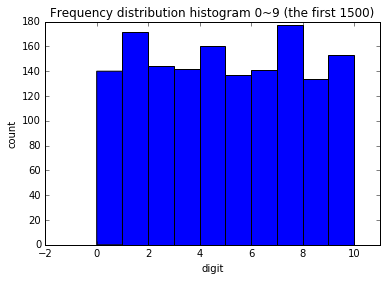

In [10]:
# visualize data
data = train_labels[:train_number]
 
bins = np.arange(0, 11, 1) # fixed bin size
 
plt.xlim([min(data)-2, max(data)+2])
 
plt.hist(data, bins=bins)
plt.title('Frequency distribution histogram 0~9 (the first 1500)')
plt.xlabel('digit')
plt.ylabel('count')
 
plt.show()

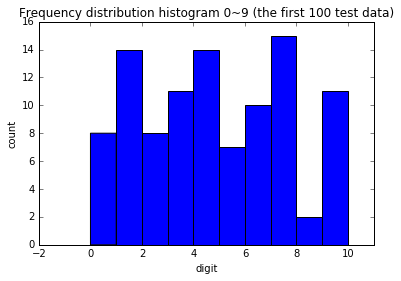

In [11]:
# test data visualization
data = test_labels[:test_number]
bins = np.arange(0, 11, 1) # fixed bin size
 
plt.xlim([min(data)-2, max(data)+2])
 
plt.hist(data, bins=bins)
plt.title('Frequency distribution histogram 0~9 (the first 100 test data)')
plt.xlabel('digit')
plt.ylabel('count')
 
plt.show()

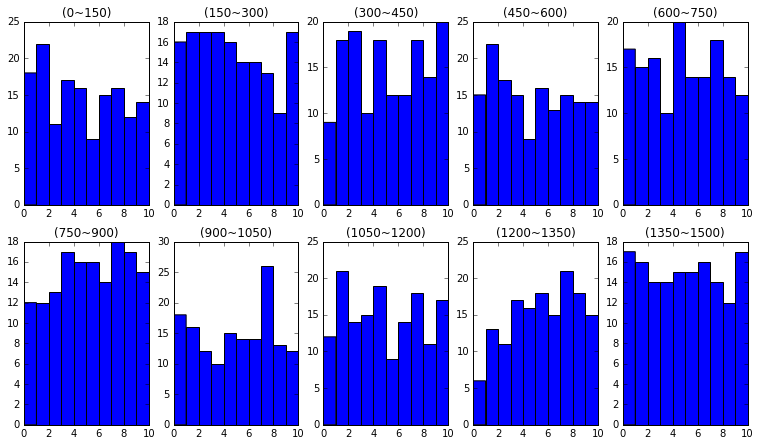

In [12]:
# k fold visualization
data = train_labels[:train_number]
f, axarr = plt.subplots(2, 5)
plt.title('Frequency distribution histogram 0~9')
axarr[0, 0].hist(data[start_index[0]:end_index[0]], bins=bins)
axarr[0, 0].set_title('(0~150)')

axarr[0, 1].hist(data[start_index[1]:end_index[1]], bins=bins)
axarr[0, 1].set_title('(150~300)')

axarr[0, 2].hist(data[start_index[2]:end_index[2]], bins=bins)
axarr[0, 2].set_title('(300~450)')

axarr[0, 3].hist(data[start_index[3]:end_index[3]], bins=bins)
axarr[0, 3].set_title('(450~600)')

axarr[0, 4].hist(data[start_index[4]:end_index[4]], bins=bins)
axarr[0, 4].set_title('(600~750)')

axarr[1, 0].hist(data[start_index[5]:end_index[5]], bins=bins)
axarr[1, 0].set_title('(750~900)')

axarr[1, 1].hist(data[start_index[6]:end_index[6]], bins=bins)
axarr[1, 1].set_title('(900~1050)')

axarr[1, 2].hist(data[start_index[7]:end_index[7]], bins=bins)
axarr[1, 2].set_title('(1050~1200)')

axarr[1, 3].hist(data[start_index[8]:end_index[8]], bins=bins)
axarr[1, 3].set_title('(1200~1350)')

axarr[1, 4].hist(data[start_index[9]:end_index[9]], bins=bins)
axarr[1, 4].set_title('(1350~1500)')
plt.subplots_adjust(bottom=0.5, right=1.8, top=1.9)  
plt.show()

In [13]:
#scikit-learn linear svm test
sci_classifier_diff_c = []
step = 1
b = 0.000000000001
for index in range(10):
    sci_classifier_diff_c.append(svm.LinearSVC(C=b + step * index))

In [14]:
expected = test_labels[:test_number]
predicted = []
predicted_images = []
for index in range(len(sci_classifier_diff_c)):
    sci_classifier_diff_c[index].fit(train_images_reduce_format[:train_number], train_labels[:train_number])
    predicted.append(sci_classifier_diff_c[index].predict(test_images_reduce_format[:test_number]))
    predicted_images.append(list(zip(expected, predicted[-1])))

In [16]:
#confusion matrix
for j in range(len(predicted_images)):
    sci_confusion_matrix = [[] for ia in range(10)]
    for s in range(10):
        for k in range(10):
            sci_confusion_matrix[s].append(0)
    for i in predicted_images[j]:
        sci_confusion_matrix[int(i[0])][int(i[1])] += 1
    for i in sci_confusion_matrix:
        print(i)
    print()

[8, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 9, 0, 2, 0, 0, 0, 0, 3, 0]
[2, 0, 4, 1, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 10, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 11, 0, 0, 1, 0, 1]
[5, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[3, 0, 0, 0, 1, 0, 6, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 15, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 6, 1, 4]

[7, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 11, 0, 1, 0, 1, 0, 0, 1, 0]
[0, 0, 6, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 9, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 13, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 2, 4, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 8, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 15, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
[0, 0, 0, 0, 1, 0, 0, 1, 0, 9]

[6, 0, 0, 0, 0, 1, 0, 0, 1, 0]
[0, 11, 0, 1, 0, 2, 0, 0, 0, 0]
[0, 0, 6, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 9, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 13, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 2, 4, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 8, 0, 1, 0]
[0, 0, 1, 0, 0, 0, 0, 13, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 10]

[7, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 12, 0, 1, 0, 0, 0, 0, 

In [94]:
#scikit-learn recall
for j in range(len(predicted_images)):
    label_count_predict = [0 for i in range(10)]
    label_count_test = [0 for i in range(10)]
    for i in predicted_images[j]:
        if i[0] == i[1]:
            label_count_predict[int(i[0])] += 1
        label_count_test[int(i[0])] += 1
    print(label_count_test)
    print(label_count_predict)
    for index in range(10):
        print(label_count_predict[index]/label_count_test[index],end=' ')
    print()
    print(sum(label_count_predict)/sum(label_count_test))
    

[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]
[8, 9, 4, 10, 11, 0, 6, 15, 1, 4]
1.0 0.6428571428571429 0.5 0.9090909090909091 0.7857142857142857 0.0 0.6 1.0 0.5 0.36363636363636365 
0.68
[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]
[7, 11, 6, 9, 13, 4, 8, 14, 2, 9]
0.875 0.7857142857142857 0.75 0.8181818181818182 0.9285714285714286 0.5714285714285714 0.8 0.9333333333333333 1.0 0.8181818181818182 
0.83
[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]
[6, 11, 6, 9, 13, 4, 8, 14, 2, 9]
0.75 0.7857142857142857 0.75 0.8181818181818182 0.9285714285714286 0.5714285714285714 0.8 0.9333333333333333 1.0 0.8181818181818182 
0.82
[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]
[7, 11, 6, 10, 13, 3, 8, 13, 2, 10]
0.875 0.7857142857142857 0.75 0.9090909090909091 0.9285714285714286 0.42857142857142855 0.8 0.8666666666666667 1.0 0.9090909090909091 
0.83
[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]
[6, 11, 6, 9, 12, 3, 8, 12, 2, 11]
0.75 0.7857142857142857 0.75 0.8181818181818182 0.8571428571428571 0.42857142857142855 0.8 0.8 1.0 1.0 
0.8
[8, 14, 8,

In [245]:
#scikit-learn precision
for j in range(3):
    label_count_predict = [0 for i in range(10)]
    label_count_test = [0 for i in range(10)]
    for i in predicted_images[j]:
        if i[0] == i[1]:
            label_count_predict[int(i[0])] += 1
        label_count_test[int(i[1])] += 1
    print(label_count_test)
    print(label_count_predict)
    for index in range(10):
        if label_count_predict[index] == 0:
            print(0.0)
        else:   
            print(label_count_predict[index]/label_count_test[index],end=' ')
    print()


[20, 9, 5, 14, 12, 0, 6, 24, 5, 5]
[8, 9, 4, 10, 11, 0, 6, 15, 1, 4]
0.4 1.0 0.8 0.7142857142857143 0.9166666666666666 0.0
1.0 0.625 0.2 0.8 
[7, 11, 7, 10, 16, 8, 8, 17, 5, 11]
[7, 11, 6, 9, 13, 4, 8, 14, 2, 9]
1.0 1.0 0.8571428571428571 0.9 0.8125 0.5 1.0 0.8235294117647058 0.4 0.8181818181818182 
[6, 11, 7, 10, 16, 8, 8, 17, 6, 11]
[6, 11, 6, 9, 13, 4, 8, 14, 2, 9]
1.0 1.0 0.8571428571428571 0.9 0.8125 0.5 1.0 0.8235294117647058 0.3333333333333333 0.8181818181818182 


In [19]:
# my svm
#data preprocessing
train_images_format = []
test_images_format = []
train_labels_format = [[] for i in range(10)]
for i in range(10):
    for index in range(train_number):
        if train_labels[index] == i:
            train_labels_format[i].append(1)
        else:
            train_labels_format[i].append(-1)

for index in range(train_number):
    train_images_format.append(list(np.reshape(train_images[index], length_feature)))
    train_images_format[-1].append(1)  # for linear in-equation
for index in range(len(test_images)):
    test_images_format.append(list(np.reshape(test_images[index], length_feature)))
    test_images_format[-1].append(1)  # for linear in-equation

In [20]:
C = 0
mysvm = [SVM(C) for i in range(10)]
prediction = []

In [21]:
for i in range(10):
    mysvm[i].train(train_images_format, train_labels_format[i]) #  classify i with other digits i from 0 to 9
    prediction.append(mysvm[i].predict(test_images_format[:test_number]))

[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]

     pcost       dcost       gap    pres   dres
 0:  2.5057e-01  2.2923e+02  6e+03  2e+00  3e+06
 1:  1.6129e+00 -1.0076e+03  1e+03  5e-01  7e+05
 2:  1.3469e+00 -1.1465e+02  1e+02  4e-02  6e+04
 3:  1.3748e-01 -1.6623e+01  2e+01  6e-03  8e+03
 4:  1.3523e-02 -1.3809e+00  1e+00  4e-04  6e+02
 5:  4.6340e-03 -2.3110e-01  2e-01  7e-05  1e+02
 6:  1.7243e-03 -4.9514e-02  5e-02  1e-05  2e+01
 7:  6.7629e-04 -1.1405e-02  1e-02  3e-06  4e+00
 8:  2.6183e-04 -2.3149e-03  3e-03  6e-07  8e-01
 9:  1.3111e-04 -3.9690e-04  5e-04  1e-07  1e-01
10:  8.4504e-05 -2.1046e-05  1e-04  2e-08  2e-02
11:  6.5421e-05  3.2983e-05  3e-05  4e-09  5e-03
12:  6.0509e-05  5.0394e-05  1e-05  4e-10  5e-04
13:  5.8861e-05  5.6600e-05  2e-06  3e-15  4e-15
14:  5.8529e-05  5.8262e-05  3e-07  3e-15  3e-15
15:  5.8501e-05  5.8494e-05  7e-09  2e-15  1e-14
Optimal solution found.
[ 0.00e+00  0.00e+00  0.00e+00 -0.00e+00  0.00e+00  0.00e+00 -0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00 -0.00e+00  0.00e+00  0.00e+00 -0.00e

 0:  1.2460e-01  3.1952e+02  7e+03  2e+00  3e+06
 1:  9.7077e-01 -1.4302e+03  2e+03  7e-01  1e+06
 2:  1.1627e+00 -1.2729e+02  1e+02  4e-02  6e+04
 3:  1.1488e-01 -1.9491e+01  2e+01  6e-03  9e+03
 4:  1.9457e-02 -2.7403e+00  3e+00  9e-04  1e+03
 5:  8.3886e-03 -5.0927e-01  5e-01  2e-04  2e+02
 6:  3.0224e-03 -7.4469e-02  8e-02  2e-05  3e+01
 7:  1.2198e-03 -1.6069e-02  2e-02  4e-06  6e+00
 8:  5.3720e-04 -3.2829e-03  4e-03  9e-07  1e+00
 9:  2.8427e-04 -9.6856e-04  1e-03  3e-07  4e-01
10:  1.8913e-04 -2.9604e-04  5e-04  9e-08  1e-01
11:  1.4364e-04 -3.8881e-06  1e-04  2e-08  3e-02
12:  1.2657e-04  8.8227e-05  4e-05  4e-09  6e-03
13:  1.2245e-04  1.1286e-04  1e-05  3e-15  7e-16
14:  1.2112e-04  1.1929e-04  2e-06  3e-15  2e-15
15:  1.2085e-04  1.2077e-04  8e-08  4e-15  3e-15
Optimal solution found.
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+

     pcost       dcost       gap    pres   dres
 0:  7.1905e-01  3.2221e+02  7e+03  3e+00  3e+06
 1:  5.2708e+00 -1.5901e+03  2e+03  8e-01  1e+06
 2:  5.6455e+00 -2.2765e+02  2e+02  8e-02  1e+05
 3:  9.0972e-01 -4.4680e+01  5e+01  1e-02  2e+04
 4:  7.7532e-02 -7.2724e+00  7e+00  2e-03  3e+03
 5:  2.9637e-02 -1.1149e+00  1e+00  3e-04  3e+02
 6:  1.1074e-02 -2.4717e-01  3e-01  6e-05  7e+01
 7:  4.1678e-03 -4.5723e-02  5e-02  1e-05  1e+01
 8:  1.7038e-03 -1.0239e-02  1e-02  2e-06  3e+00
 9:  9.9671e-04 -3.7040e-03  5e-03  8e-07  9e-01
10:  5.7775e-04 -2.7453e-04  9e-04  9e-08  1e-01
11:  3.9056e-04  1.7192e-04  2e-04  2e-08  2e-02
12:  3.4420e-04  2.7443e-04  7e-05  3e-09  3e-03
13:  3.3288e-04  3.0728e-04  3e-05  3e-10  3e-04
14:  3.2762e-04  3.2262e-04  5e-06  3e-11  4e-05
15:  3.2669e-04  3.2620e-04  5e-07  2e-12  3e-06
16:  3.2660e-04  3.2658e-04  1e-08  6e-14  7e-08
Optimal solution found.
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+

 2:  5.6688e+00 -3.2138e+02  3e+02  1e-01  2e+05
 3:  1.9194e+00 -8.5773e+01  9e+01  3e-02  3e+04
 4:  2.3446e-01 -2.4952e+01  3e+01  7e-03  9e+03
 5:  5.1458e-02 -2.8190e+00  3e+00  7e-04  9e+02
 6:  1.7777e-02 -5.5991e-01  6e-01  1e-04  2e+02
 7:  7.2297e-03 -1.2743e-01  1e-01  3e-05  4e+01
 8:  3.0748e-03 -2.6736e-02  3e-02  6e-06  7e+00
 9:  1.5287e-03 -7.3056e-03  9e-03  2e-06  2e+00
10:  9.0566e-04 -1.5717e-03  2e-03  4e-07  5e-01
11:  5.4447e-04  1.5897e-04  4e-04  2e-08  3e-02
12:  4.6209e-04  3.1048e-04  2e-04  6e-09  7e-03
13:  4.3440e-04  3.7954e-04  5e-05  3e-15  5e-15
14:  4.2205e-04  4.1078e-04  1e-05  3e-15  8e-15
15:  4.1962e-04  4.1906e-04  6e-07  3e-15  1e-14
16:  4.1952e-04  4.1951e-04  1e-08  4e-15  6e-14
Optimal solution found.
[ 0.00e+00  0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00 -0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00

 1:  1.1099e+00 -1.1881e+03  2e+03  7e-01  1e+06
 2:  1.2035e+00 -1.2706e+02  1e+02  4e-02  6e+04
 3:  1.5813e-01 -2.2066e+01  2e+01  7e-03  1e+04
 4:  3.1713e-02 -2.6358e+00  3e+00  8e-04  1e+03
 5:  1.1761e-02 -4.7552e-01  5e-01  1e-04  2e+02
 6:  4.6511e-03 -1.0349e-01  1e-01  2e-05  3e+01
 7:  1.8530e-03 -1.9867e-02  2e-02  4e-06  6e+00
 8:  7.7835e-04 -4.7258e-03  6e-03  1e-06  1e+00
 9:  4.1490e-04 -1.2128e-03  2e-03  3e-07  4e-01
10:  2.7747e-04 -1.7291e-04  5e-04  6e-08  9e-02
11:  2.1479e-04  1.0381e-04  1e-04  1e-08  2e-02
12:  2.0077e-04  1.6382e-04  4e-05  4e-09  6e-03
13:  1.9603e-04  1.8803e-04  8e-06  3e-15  2e-15
14:  1.9503e-04  1.9341e-04  2e-06  3e-15  4e-15
15:  1.9481e-04  1.9475e-04  5e-08  4e-15  7e-15
Optimal solution found.
[-0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[-0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[-0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[-0.00e+00


     pcost       dcost       gap    pres   dres
 0:  2.7932e-01  4.8100e+02  8e+03  3e+00  4e+06
 1:  1.9339e+00 -2.3100e+03  4e+03  1e+00  2e+06
 2:  2.6680e+00 -3.3603e+02  3e+02  9e-02  1e+05
 3:  6.3465e-01 -5.3927e+01  5e+01  1e-02  2e+04
 4:  7.9122e-02 -7.1018e+00  7e+00  2e-03  2e+03
 5:  2.8298e-02 -1.2105e+00  1e+00  3e-04  4e+02
 6:  1.1162e-02 -2.8049e-01  3e-01  6e-05  9e+01
 7:  5.2953e-03 -6.8198e-02  7e-02  1e-05  2e+01
 8:  2.6998e-03 -1.5844e-02  2e-02  3e-06  4e+00
 9:  1.5629e-03 -3.6507e-03  5e-03  6e-07  9e-01
10:  8.3972e-04  1.4211e-04  7e-04  2e-08  3e-02
11:  6.1172e-04  3.7608e-04  2e-04  6e-09  9e-03
12:  5.5945e-04  4.7709e-04  8e-05  6e-10  8e-04
13:  5.3967e-04  5.1739e-04  2e-05  7e-11  1e-04
14:  5.3446e-04  5.3166e-04  3e-06  2e-12  3e-06
15:  5.3390e-04  5.3378e-04  1e-07  7e-14  1e-07
16:  5.3388e-04  5.3387e-04  3e-09  4e-15  3e-09
Optimal solution found.
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e

 1:  4.1096e+00 -1.0254e+03  1e+03  5e-01  7e+05
 2:  3.8681e+00 -1.4954e+02  2e+02  6e-02  8e+04
 3:  5.1832e-01 -2.7953e+01  3e+01  1e-02  1e+04
 4:  3.1469e-02 -4.0232e+00  4e+00  1e-03  2e+03
 5:  9.1784e-03 -5.9730e-01  6e-01  2e-04  3e+02
 6:  3.3192e-03 -7.4659e-02  8e-02  2e-05  3e+01
 7:  1.1108e-03 -1.5270e-02  2e-02  5e-06  6e+00
 8:  4.4706e-04 -3.6969e-03  4e-03  1e-06  1e+00
 9:  2.2972e-04 -1.0323e-03  1e-03  3e-07  4e-01
10:  1.3696e-04 -2.0917e-04  3e-04  7e-08  1e-01
11:  1.0179e-04 -9.7698e-06  1e-04  2e-08  3e-02
12:  8.7199e-05  6.4479e-05  2e-05  7e-10  1e-03
13:  8.3942e-05  7.7387e-05  7e-06  1e-10  2e-04
14:  8.3024e-05  8.1838e-05  1e-06  1e-11  2e-05
15:  8.2869e-05  8.2833e-05  4e-08  2e-13  3e-07
16:  8.2864e-05  8.2863e-05  8e-10  5e-15  6e-09
Optimal solution found.
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+


     pcost       dcost       gap    pres   dres
 0:  3.8530e-01  3.0419e+02  6e+03  2e+00  3e+06
 1:  2.5034e+00 -1.4389e+03  2e+03  9e-01  1e+06
 2:  2.9054e+00 -2.5676e+02  3e+02  1e-01  1e+05
 3:  6.7310e-01 -5.0181e+01  5e+01  2e-02  2e+04
 4:  8.6260e-02 -1.1317e+01  1e+01  3e-03  4e+03
 5:  2.9191e-02 -1.9006e+00  2e+00  5e-04  6e+02
 6:  9.8040e-03 -2.8155e-01  3e-01  7e-05  8e+01
 7:  3.3753e-03 -5.1688e-02  6e-02  1e-05  1e+01
 8:  1.4172e-03 -1.4553e-02  2e-02  3e-06  4e+00
 9:  6.1522e-04 -3.1091e-03  4e-03  6e-07  8e-01
10:  3.5602e-04 -8.1524e-04  1e-03  2e-07  2e-01
11:  2.2870e-04 -1.4989e-05  2e-04  2e-08  3e-02
12:  1.8716e-04  1.1578e-04  7e-05  5e-09  6e-03
13:  1.7729e-04  1.5599e-04  2e-05  4e-10  5e-04
14:  1.7390e-04  1.7040e-04  4e-06  4e-15  2e-15
15:  1.7351e-04  1.7283e-04  7e-07  4e-15  3e-15
16:  1.7343e-04  1.7341e-04  2e-08  5e-15  6e-15
Optimal solution found.
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e

 1:  6.5807e+00 -1.4352e+03  2e+03  9e-01  1e+06
 2:  9.6810e+00 -3.0765e+02  3e+02  1e-01  1e+05
 3:  3.1035e+00 -8.2826e+01  9e+01  3e-02  3e+04
 4:  2.0874e-01 -1.3425e+01  1e+01  4e-03  5e+03
 5:  5.1825e-02 -1.3738e+00  1e+00  4e-04  4e+02
 6:  1.9359e-02 -3.4363e-01  4e-01  9e-05  1e+02
 7:  7.9868e-03 -8.0111e-02  9e-02  2e-05  2e+01
 8:  3.8190e-03 -2.3334e-02  3e-02  5e-06  6e+00
 9:  2.2152e-03 -6.8340e-03  9e-03  1e-06  2e+00
10:  1.3533e-03 -9.6947e-04  2e-03  3e-07  3e-01
11:  9.2895e-04  3.5728e-04  6e-04  5e-08  6e-02
12:  8.3179e-04  6.3126e-04  2e-04  1e-08  1e-02
13:  8.0528e-04  7.2295e-04  8e-05  4e-15  6e-15
14:  7.8816e-04  7.7358e-04  1e-05  4e-15  1e-14
15:  7.8519e-04  7.8390e-04  1e-06  4e-15  2e-14
16:  7.8498e-04  7.8494e-04  4e-08  4e-15  6e-14
Optimal solution found.
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00 -0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00 -0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+

     pcost       dcost       gap    pres   dres
 0:  4.0473e-01  4.9849e+02  7e+03  3e+00  3e+06
 1:  3.3169e+00 -1.4993e+03  3e+03  1e+00  1e+06
 2:  5.2496e+00 -5.0122e+02  6e+02  2e-01  2e+05
 3:  2.3353e+00 -9.1514e+01  1e+02  3e-02  4e+04
 4:  2.1903e-01 -1.5658e+01  2e+01  4e-03  6e+03
 5:  5.8267e-02 -2.9832e+00  3e+00  8e-04  1e+03
 6:  2.3511e-02 -6.0577e-01  6e-01  2e-04  2e+02
 7:  1.0780e-02 -1.4436e-01  2e-01  3e-05  4e+01
 8:  5.0069e-03 -3.0945e-02  4e-02  7e-06  9e+00
 9:  2.8922e-03 -1.0402e-02  1e-02  2e-06  3e+00
10:  1.9451e-03 -3.2286e-03  5e-03  8e-07  1e+00
11:  1.4554e-03 -2.0704e-04  2e-03  2e-07  3e-01
12:  1.1935e-03  7.2195e-04  5e-04  5e-08  7e-02
13:  1.1255e-03  9.9469e-04  1e-04  1e-08  1e-02
14:  1.1035e-03  1.0864e-03  2e-05  5e-10  6e-04
15:  1.1005e-03  1.0998e-03  7e-07  1e-11  2e-05
16:  1.1004e-03  1.1004e-03  2e-08  3e-13  4e-07
17:  1.1004e-03  1.1004e-03  4e-10  5e-15  4e-09
Optimal solution found.


In [24]:
print(test_labels)

[ 7.  2.  1. ...,  4.  5.  6.]


In [25]:
# confusion matrix by my svm
my_confusion_matrix = [[] for i in range(10)]
for i in range(10):
    for j in range(10):
        my_confusion_matrix[i].append(0)
for i in range(10):
    for j in range(len(prediction[i])):
        if prediction[i][j] >= 0:
            my_confusion_matrix[int(test_labels[j])][i] += 1
for k in my_confusion_matrix:
    print(k)

[8, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 12, 0, 2, 0, 0, 0, 0, 0, 0]
[0, 0, 6, 0, 1, 1, 0, 0, 0, 0]
[0, 0, 1, 10, 0, 0, 0, 0, 0, 1]
[0, 0, 1, 1, 14, 0, 1, 0, 1, 2]
[1, 0, 0, 0, 1, 5, 0, 1, 2, 0]
[0, 0, 0, 0, 1, 1, 8, 0, 0, 0]
[0, 0, 1, 0, 0, 1, 0, 13, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
[0, 0, 0, 0, 0, 0, 0, 2, 0, 8]


In [98]:
my_svm_count = [0 for i in range(10)]
my_svm_total = [0 for i in range(10)]
for i in range(10):
    for index in range(len(prediction[i])):
        if test_labels[index] == i:
            my_svm_total[i] += 1
            if prediction[i][index] >= 0:
                my_svm_count[i] += 1

In [246]:
my_svm_count = [0 for i in range(10)]
my_svm_total = [0 for i in range(10)]
for i in range(10):
    for index in range(len(prediction[i])):
        if prediction[i][index] >= 0:
            my_svm_total[i] += 1
            if test_labels[index] == i:
                my_svm_count[i] += 1

In [247]:
# precision my svm
for i in range(10):
    print(my_svm_count[i]/my_svm_total[i],end=' ')
print()
print(sum(my_svm_count)/sum(my_svm_total))

0.8888888888888888 1.0 0.6666666666666666 0.7692307692307693 0.8235294117647058 0.625 0.8888888888888888 0.8125 0.3333333333333333 0.7272727272727273 
0.7818181818181819


In [99]:
# recall my svm
for i in range(10):
    print(my_svm_count[i]/my_svm_total[i],end=' ')
print()
print(sum(my_svm_count)/sum(my_svm_total))

1.0 0.8571428571428571 0.75 0.9090909090909091 1.0 0.7142857142857143 0.8 0.8666666666666667 1.0 0.7272727272727273 
0.86


In [100]:
# c=1 my svm
C_1 = 1
mysvm_1 = [SVM(C_1) for i in range(10)]
prediction_1 = []

In [101]:

for i in range(0,10):
    mysvm_1[i].train(train_images_format, train_labels_format[i]) #  classify i with other digits i from 0 to 9
    prediction_1.append(mysvm_1[i].predict(test_images_format[:test_number]))

     pcost       dcost       gap    pres   dres
 0: -1.4152e+03  2.6242e+03  1e+04  4e+00  8e+04
 1:  7.5513e+02 -9.8536e+02  3e+03  6e-01  1e+04
 2:  3.8649e+02 -4.5748e+02  1e+03  2e-01  5e+03
 3:  5.0175e+01 -3.3345e+01  1e+02  2e-02  3e+02
 4:  5.2924e+00 -2.3136e+00  9e+00  1e-03  2e+01
 5:  7.9652e-01 -3.2437e-01  1e+00  1e-04  3e+00
 6:  1.7415e-01 -5.8154e-02  3e-01  2e-05  4e-01
 7:  4.9058e-02 -1.5686e-02  7e-02  5e-06  1e-01
 8:  9.6137e-03 -2.7617e-03  1e-02  8e-07  2e-02
 9:  1.6011e-03 -3.9984e-04  2e-03  1e-07  2e-03
10:  9.1321e-05  7.9138e-06  8e-05  1e-09  3e-05
11:  5.9140e-05  2.6454e-05  3e-05  4e-10  8e-06
12:  4.8503e-05  3.6051e-05  1e-05  5e-11  1e-06
13:  4.3358e-05  3.9786e-05  4e-06  3e-12  7e-08
14:  4.1497e-05  4.1048e-05  4e-07  2e-13  5e-09
15:  4.1246e-05  4.1237e-05  9e-09  5e-15  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.3853e+03  2.7938e+03  1e+04  4e+00  9e+04
 1:  8.4755e+02 -1.1555e+03  3e+03  6e-01  1e+0

15:  4.7127e-04  4.5825e-04  1e-05  5e-15  7e-16
16:  4.6444e-04  4.6279e-04  2e-06  5e-15  9e-16
17:  4.6348e-04  4.6344e-04  4e-08  5e-15  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.3215e+03  2.8585e+03  1e+04  4e+00  8e+04
 1:  8.5557e+02 -1.2453e+03  3e+03  7e-01  2e+04
 2:  4.5002e+02 -4.9088e+02  1e+03  2e-01  5e+03
 3:  2.5620e+02 -2.8821e+02  7e+02  1e-01  3e+03
 4:  1.6490e+02 -1.2716e+02  3e+02  4e-02  8e+02
 5:  2.2599e+01 -1.2975e+01  4e+01  4e-03  8e+01
 6:  6.5577e+00 -2.9176e+00  1e+01  7e-04  2e+01
 7:  1.4515e+00 -5.7579e-01  2e+00  1e-04  3e+00
 8:  3.6272e-01 -1.2129e-01  5e-01  2e-05  5e-01
 9:  8.6199e-02 -2.6296e-02  1e-01  5e-06  1e-01
10:  2.6230e-02 -6.9797e-03  3e-02  1e-06  3e-02
11:  6.0148e-03 -8.7830e-04  7e-03  2e-07  4e-03
12:  2.6373e-03  1.0431e-04  3e-03  7e-08  1e-03
13:  1.1278e-03  4.9541e-04  6e-04  8e-15  8e-16
14:  8.8135e-04  5.9628e-04  3e-04  6e-15  9e-16
15:  7.4385e-04  6.5450e-04  9e-05  6e-15  9e-

In [102]:
# my svm recall
my_svm_count_1 = [0 for i in range(10)]
my_svm_total_1 = [0 for i in range(10)]
for i in range(10):
    for index in range(len(prediction_1[i])):
        if test_labels[index] == i:
            my_svm_total_1[i] += 1
            if prediction_1[i][index] >= 0:
                my_svm_count_1[i] += 1

In [103]:
for i in range(10):
    print(my_svm_count_1[i]/my_svm_total_1[i],end=' ')
print(sum(my_svm_count_1)/sum(my_svm_total_1))

1.0 0.9285714285714286 0.625 0.8181818181818182 1.0 0.7142857142857143 0.7 0.8 0.5 0.6363636363636364 0.81


In [248]:
# my svm precision
my_svm_count_1 = [0 for i in range(10)]
my_svm_total_1 = [0 for i in range(10)]
for i in range(10):
    for index in range(len(prediction_1[i])):
        if prediction_1[i][index] >= 0:
            my_svm_total_1[i] += 1
            if test_labels[index] == i:
                my_svm_count_1[i] += 1
for i in range(10):
    print(my_svm_count_1[i]/my_svm_total_1[i],end=' ')

0.8888888888888888 1.0 0.7142857142857143 0.8181818181818182 0.875 0.625 0.875 0.8571428571428571 0.5 0.6363636363636364 

In [112]:
#my svm c=2
C_2 = 2
mysvm_2 = [SVM(C_2) for i in range(10)]
prediction_2 = []

In [113]:
for i in range(10):
    mysvm_2[i].train(train_images_format, train_labels_format[i]) #  classify i with other digits i from 0 to 9
    prediction_2.append(mysvm_2[i].predict(test_images_format[:test_number]))

     pcost       dcost       gap    pres   dres
 0: -5.7456e+03  6.2455e+03  2e+04  6e+00  5e+04
 1:  6.6208e+02 -1.7002e+03  5e+03  9e-01  8e+03
 2:  3.0456e+02 -5.9966e+02  1e+03  3e-01  2e+03
 3:  2.6063e+01 -4.4535e+01  1e+02  2e-02  2e+02
 4:  3.9125e+00 -3.0521e+00  9e+00  1e-03  1e+01
 5:  6.8381e-01 -4.8763e-01  2e+00  2e-04  2e+00
 6:  1.2595e-01 -6.7862e-02  2e-01  2e-05  2e-01
 7:  3.9004e-02 -1.8805e-02  7e-02  6e-06  5e-02
 8:  6.7314e-03 -2.7822e-03  1e-02  8e-07  7e-03
 9:  1.2170e-03 -4.0880e-04  2e-03  1e-07  1e-03
10:  8.2468e-05  4.6250e-06  8e-05  1e-09  1e-05
11:  5.6596e-05  2.5052e-05  3e-05  3e-10  3e-06
12:  5.0701e-05  3.3000e-05  2e-05  1e-10  1e-06
13:  4.4547e-05  3.8671e-05  6e-06  2e-11  1e-07
14:  4.2015e-05  4.0648e-05  1e-06  3e-15  4e-16
15:  4.1264e-05  4.1222e-05  4e-08  3e-15  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.6560e+03  6.7094e+03  3e+04  6e+00  5e+04
 1:  8.3915e+02 -2.0451e+03  6e+03  1e+00  1e+0

15:  4.6994e-04  4.5899e-04  1e-05  4e-15  5e-16
16:  4.6415e-04  4.6297e-04  1e-06  4e-15  6e-16
17:  4.6347e-04  4.6344e-04  3e-08  5e-15  8e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.4645e+03  6.8080e+03  3e+04  6e+00  5e+04
 1:  8.5689e+02 -2.1574e+03  7e+03  1e+00  1e+04
 2:  5.2711e+02 -1.1182e+03  3e+03  5e-01  4e+03
 3:  3.6759e+02 -7.4260e+02  2e+03  3e-01  2e+03
 4:  1.3203e+02 -8.6290e+01  3e+02  3e-02  2e+02
 5:  2.2381e+01 -1.3388e+01  4e+01  4e-03  3e+01
 6:  5.1028e+00 -2.4333e+00  9e+00  6e-04  6e+00
 7:  1.1308e+00 -4.6549e-01  2e+00  1e-04  1e+00
 8:  2.9663e-01 -1.0551e-01  4e-01  2e-05  2e-01
 9:  8.5459e-02 -2.7827e-02  1e-01  5e-06  5e-02
10:  2.4848e-02 -6.9395e-03  3e-02  1e-06  1e-02
11:  3.0307e-03 -2.1959e-04  3e-03  7e-08  6e-04
12:  1.6951e-03  2.6723e-04  1e-03  3e-08  3e-04
13:  1.0388e-03  5.2595e-04  5e-04  4e-09  3e-05
14:  7.9472e-04  6.3054e-04  2e-04  7e-15  6e-16
15:  7.1499e-04  6.7136e-04  4e-05  5e-15  5e-

In [114]:
# my svm recall
my_svm_count_2 = [0 for i in range(10)]
my_svm_total_2 = [0 for i in range(10)]
for i in range(10):
    for index in range(len(prediction_2[i])):
        if test_labels[index] == i:
            my_svm_total_2[i] += 1
            if prediction_2[i][index] >= 0:
                my_svm_count_2[i] += 1
for i in range(10):
    print(my_svm_count_2[i]/my_svm_total_2[i],end=' ')
print(sum(my_svm_count_2)/sum(my_svm_total_2))

1.0 0.9285714285714286 0.625 0.8181818181818182 1.0 0.7142857142857143 0.7 0.8 0.5 0.6363636363636364 0.81


In [249]:
#my svm precision
my_svm_count_2 = [0 for i in range(10)]
my_svm_total_2 = [0 for i in range(10)]
for i in range(10):
    for index in range(len(prediction_2[i])):
        if prediction_2[i][index] >= 0:
            my_svm_total_2[i] += 1
            if test_labels[index] == i:
                my_svm_count_2[i] += 1
for i in range(10):
    print(my_svm_count_2[i]/my_svm_total_2[i],end=' ')

0.8888888888888888 1.0 0.7142857142857143 0.8181818181818182 0.875 0.625 0.875 0.8571428571428571 0.5 0.6363636363636364 

In [107]:
# my svm c=3
C_3 = 3
mysvm_3 = [SVM(C_3) for i in range(10)]
prediction_3 = []

In [108]:
for i in range(10):
    mysvm_3[i].train(train_images_format, train_labels_format[i]) #  classify i with other digits i from 0 to 9
    prediction_3.append(mysvm_3[i].predict(test_images_format[:test_number]))

     pcost       dcost       gap    pres   dres
 0: -1.2991e+04  1.0906e+04  4e+04  8e+00  4e+04
 1:  1.6975e+02 -2.5596e+03  7e+03  1e+00  6e+03
 2:  1.8590e+02 -6.3210e+02  2e+03  2e-01  1e+03
 3:  1.7683e+01 -5.6536e+01  1e+02  2e-02  1e+02
 4:  2.8183e+00 -3.9828e+00  1e+01  1e-03  7e+00
 5:  5.1012e-01 -6.0965e-01  2e+00  2e-04  1e+00
 6:  1.0199e-01 -8.3506e-02  3e-01  3e-05  1e-01
 7:  3.1942e-02 -2.0943e-02  7e-02  6e-06  3e-02
 8:  5.0282e-03 -2.7844e-03  1e-02  8e-07  4e-03
 9:  8.2265e-04 -3.2931e-04  1e-03  8e-08  4e-04
10:  7.9991e-05  4.5361e-06  8e-05  1e-09  5e-06
11:  5.7495e-05  2.4704e-05  3e-05  3e-10  1e-06
12:  5.1478e-05  3.3012e-05  2e-05  9e-11  4e-07
13:  4.4682e-05  3.8674e-05  6e-06  1e-11  6e-08
14:  4.1985e-05  4.0672e-05  1e-06  3e-15  5e-16
15:  4.1262e-05  4.1223e-05  4e-08  3e-15  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2812e+04  1.1804e+04  4e+04  8e+00  4e+04
 1:  4.1245e+02 -3.1181e+03  9e+03  1e+00  8e+0

14:  5.0278e-04  4.4335e-04  6e-05  5e-15  5e-16
15:  4.6984e-04  4.5913e-04  1e-05  5e-15  6e-16
16:  4.6413e-04  4.6298e-04  1e-06  4e-15  6e-16
17:  4.6347e-04  4.6344e-04  3e-08  5e-15  6e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2429e+04  1.1938e+04  4e+04  8e+00  4e+04
 1:  4.3200e+02 -3.3069e+03  1e+04  2e+00  8e+03
 2:  3.6686e+02 -1.6530e+03  4e+03  6e-01  3e+03
 3:  3.7130e+02 -4.4886e+02  1e+03  1e-01  6e+02
 4:  3.5959e+01 -4.1551e+01  1e+02  1e-02  6e+01
 5:  8.0520e+00 -6.3810e+00  2e+01  2e-03  8e+00
 6:  1.9701e+00 -1.2040e+00  4e+00  3e-04  1e+00
 7:  5.4172e-01 -2.5355e-01  1e+00  5e-05  3e-01
 8:  1.2152e-01 -5.0366e-02  2e-01  9e-06  5e-02
 9:  3.5473e-02 -1.2436e-02  5e-02  2e-06  1e-02
10:  7.0669e-03 -1.5221e-03  9e-03  3e-07  1e-03
11:  2.0899e-03  1.2104e-04  2e-03  6e-08  3e-04
12:  1.3535e-03  4.3078e-04  9e-04  8e-15  4e-16
13:  9.1318e-04  5.8307e-04  3e-04  7e-15  6e-16
14:  7.8445e-04  6.3414e-04  2e-04  6e-15  4e-

In [109]:
my_svm_count_3 = [0 for i in range(10)]
my_svm_total_3 = [0 for i in range(10)]
for i in range(10):
    for index in range(len(prediction_3[i])):
        if test_labels[index] == i:
            my_svm_total_3[i] += 1
            if prediction_3[i][index] >= 0:
                my_svm_count_3[i] += 1
for i in range(10):
    print(my_svm_count_3[i]/my_svm_total_3[i],end=' ')
print(sum(my_svm_count_3)/sum(my_svm_total_3))

1.0 0.9285714285714286 0.625 0.8181818181818182 1.0 0.7142857142857143 0.7 0.8 0.5 0.6363636363636364 0.81


In [222]:
## cross validation my svm c=1
cv_C = 1
cv_svm = []
cv_prediction = []
for i in range(10):
    cv_svm.append([SVM(cv_C) for j in range(10)])
    cv_prediction.append([[] for j in range(10)])
for i in range(0,10):
    cv_test_label = [[] for s in range(10)]
    cv_test_data = train_images_format[start_index[i]:end_index[i]]
    for s in range(10):
        cv_test_label[s] = train_labels_format[s][start_index[i]:end_index[i]]
    cv_train_data = train_images_format[:start_index[i]] + train_images_format[end_index[i]:]
    cv_train_label = []
    #cv_train_label = train_labels_format[:][:start_index[i]] + train_labels_format[:][end_index[i]:]
    for k in range(10):
        cv_train_label.append(train_labels_format[k][:start_index[i]] + train_labels_format[k][end_index[i]:])
    for j in range(10):
        cv_svm[i][j].train(cv_train_data, cv_train_label[j])
        cv_prediction[i][j] = cv_svm[i][j].predict(cv_test_data)

     pcost       dcost       gap    pres   dres
 0: -1.2759e+03  2.3343e+03  1e+04  4e+00  8e+04
 1:  6.5770e+02 -8.8273e+02  2e+03  6e-01  1e+04
 2:  3.6096e+02 -4.4668e+02  1e+03  2e-01  5e+03
 3:  5.0859e+01 -3.2618e+01  1e+02  2e-02  3e+02
 4:  4.6079e+00 -2.4681e+00  8e+00  1e-03  2e+01
 5:  5.8154e-01 -2.6721e-01  1e+00  1e-04  3e+00
 6:  1.2445e-01 -4.6818e-02  2e-01  2e-05  4e-01
 7:  3.3233e-02 -1.1693e-02  5e-02  5e-06  9e-02
 8:  7.1392e-03 -2.2606e-03  1e-02  8e-07  2e-02
 9:  1.4322e-03 -3.8882e-04  2e-03  1e-07  3e-03
10:  7.7538e-05  1.0434e-05  7e-05  8e-10  2e-05
11:  5.3943e-05  2.6749e-05  3e-05  3e-10  5e-06
12:  4.6086e-05  3.5564e-05  1e-05  4e-11  8e-07
13:  4.2112e-05  3.8732e-05  3e-06  2e-12  4e-08
14:  4.0504e-05  3.9834e-05  7e-07  3e-13  6e-09
15:  4.0133e-05  4.0097e-05  4e-08  5e-15  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2567e+03  2.5656e+03  1e+04  4e+00  9e+04
 1:  7.8975e+02 -1.1179e+03  3e+03  6e-01  1e+0

     pcost       dcost       gap    pres   dres
 0: -1.2038e+03  2.4657e+03  1e+04  4e+00  8e+04
 1:  6.9459e+02 -1.0442e+03  3e+03  7e-01  1e+04
 2:  4.1615e+02 -5.0707e+02  1e+03  3e-01  5e+03
 3:  2.7466e+02 -3.3742e+02  8e+02  2e-01  3e+03
 4:  9.1580e+01 -5.3149e+01  2e+02  2e-02  4e+02
 5:  1.7616e+01 -9.1038e+00  3e+01  3e-03  7e+01
 6:  4.1112e+00 -1.4166e+00  6e+00  4e-04  9e+00
 7:  1.1375e+00 -3.6199e-01  2e+00  1e-04  2e+00
 8:  2.4413e-01 -6.9375e-02  3e-01  2e-05  3e-01
 9:  6.4903e-02 -1.7381e-02  9e-02  4e-06  7e-02
10:  2.1735e-02 -5.2682e-03  3e-02  1e-06  2e-02
11:  3.6510e-03 -4.4375e-04  4e-03  1e-07  2e-03
12:  1.4736e-03  1.5382e-04  1e-03  4e-08  8e-04
13:  6.8128e-04  3.6699e-04  3e-04  7e-15  7e-16
14:  5.3791e-04  4.2913e-04  1e-04  5e-15  6e-16
15:  4.7881e-04  4.5705e-04  2e-05  6e-15  7e-16
16:  4.6648e-04  4.6478e-04  2e-06  5e-15  7e-16
17:  4.6552e-04  4.6547e-04  6e-08  5e-15  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dre

     pcost       dcost       gap    pres   dres
 0: -1.2271e+03  2.4420e+03  1e+04  4e+00  8e+04
 1:  7.1105e+02 -9.7299e+02  3e+03  6e-01  1e+04
 2:  3.5694e+02 -4.3208e+02  1e+03  2e-01  5e+03
 3:  1.4977e+02 -1.0689e+02  3e+02  4e-02  9e+02
 4:  1.5579e+01 -9.8109e+00  3e+01  4e-03  8e+01
 5:  3.3064e+00 -1.3668e+00  5e+00  5e-04  1e+01
 6:  7.2087e-01 -2.6013e-01  1e+00  9e-05  2e+00
 7:  1.4527e-01 -4.8419e-02  2e-01  1e-05  3e-01
 8:  3.3873e-02 -1.0243e-02  5e-02  3e-06  6e-02
 9:  1.1095e-02 -2.8839e-03  1e-02  9e-07  2e-02
10:  2.2534e-03 -1.8124e-04  3e-03  1e-07  2e-03
11:  9.0015e-04  2.0087e-04  7e-04  3e-08  6e-04
12:  5.5360e-04  3.0374e-04  2e-04  6e-15  7e-16
13:  4.4269e-04  3.4716e-04  1e-04  4e-15  6e-16
14:  3.9057e-04  3.6987e-04  2e-05  5e-15  7e-16
15:  3.7889e-04  3.7711e-04  2e-06  5e-15  1e-15
16:  3.7790e-04  3.7783e-04  7e-08  4e-15  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2018e+03  2.4654e+03  1e+04  4e+00  8e+0

     pcost       dcost       gap    pres   dres
 0: -1.2515e+03  2.3646e+03  1e+04  4e+00  8e+04
 1:  6.4217e+02 -9.6529e+02  3e+03  6e-01  1e+04
 2:  3.1766e+02 -4.1152e+02  1e+03  2e-01  5e+03
 3:  1.4325e+02 -1.4991e+02  4e+02  7e-02  1e+03
 4:  1.8663e+01 -1.7607e+01  4e+01  9e-03  2e+02
 5:  5.6567e+00 -2.7927e+00  1e+01  1e-03  2e+01
 6:  9.9491e-01 -4.2009e-01  2e+00  2e-04  3e+00
 7:  2.1020e-01 -7.7639e-02  3e-01  3e-05  5e-01
 8:  5.9889e-02 -2.0282e-02  9e-02  6e-06  1e-01
 9:  1.6099e-02 -4.9764e-03  2e-02  1e-06  3e-02
10:  6.6795e-03 -1.9307e-03  9e-03  5e-07  1e-02
11:  2.4023e-03 -5.4925e-04  3e-03  1e-07  3e-03
12:  5.3284e-04  6.9607e-06  5e-04  2e-08  5e-04
13:  2.2178e-04  1.1062e-04  1e-04  6e-15  7e-16
14:  1.7254e-04  1.3470e-04  4e-05  4e-15  5e-16
15:  1.5329e-04  1.4506e-04  8e-06  4e-15  5e-16
16:  1.4866e-04  1.4823e-04  4e-07  4e-15  4e-16
17:  1.4842e-04  1.4841e-04  1e-08  4e-15  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dre

17:  4.3233e-04  4.3232e-04  7e-09  6e-15  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2865e+03  2.3563e+03  1e+04  4e+00  8e+04
 1:  6.4373e+02 -1.0012e+03  3e+03  6e-01  1e+04
 2:  2.6984e+02 -3.2898e+02  8e+02  2e-01  4e+03
 3:  5.5547e+01 -3.5976e+01  1e+02  2e-02  4e+02
 4:  3.8155e+00 -2.2697e+00  7e+00  1e-03  2e+01
 5:  6.5433e-01 -3.0331e-01  1e+00  1e-04  3e+00
 6:  8.8383e-02 -3.6861e-02  1e-01  2e-05  3e-01
 7:  1.8113e-02 -7.0523e-03  3e-02  3e-06  6e-02
 8:  4.8438e-03 -1.6929e-03  7e-03  7e-07  1e-02
 9:  1.7566e-03 -5.3202e-04  2e-03  2e-07  4e-03
10:  3.6393e-04 -4.7150e-05  4e-04  2e-08  5e-04
11:  1.4000e-04  2.2152e-05  1e-04  5e-09  1e-04
12:  1.1236e-04  3.2775e-05  8e-05  2e-15  3e-16
13:  7.2232e-05  4.6970e-05  3e-05  3e-15  4e-16
14:  6.2009e-05  5.2150e-05  1e-05  2e-15  4e-16
15:  5.7197e-05  5.4666e-05  3e-06  2e-15  5e-16
16:  5.5821e-05  5.5694e-05  1e-07  2e-15  4e-16
17:  5.5754e-05  5.5750e-05  5e-09  2e-15  4e-

12:  2.6125e-04  1.0536e-04  2e-04  6e-09  1e-04
13:  1.7680e-04  1.3658e-04  4e-05  3e-15  5e-16
14:  1.5621e-04  1.4742e-04  9e-06  3e-15  4e-16
15:  1.5133e-04  1.5028e-04  1e-06  3e-15  5e-16
16:  1.5075e-04  1.5073e-04  2e-08  3e-15  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2247e+03  2.8329e+03  2e+04  4e+00  9e+04
 1:  8.4439e+02 -1.7758e+03  4e+03  1e+00  2e+04
 2:  5.1294e+02 -5.7097e+02  1e+03  2e-01  5e+03
 3:  3.2159e+02 -3.4867e+02  8e+02  1e-01  3e+03
 4:  1.2317e+02 -6.2578e+01  2e+02  2e-02  4e+02
 5:  1.9569e+01 -8.8497e+00  3e+01  3e-03  6e+01
 6:  4.0971e+00 -1.5476e+00  6e+00  4e-04  1e+01
 7:  9.3578e-01 -3.3510e-01  1e+00  9e-05  2e+00
 8:  3.1148e-01 -9.9983e-02  4e-01  2e-05  5e-01
 9:  8.7498e-02 -2.5880e-02  1e-01  5e-06  1e-01
10:  2.1305e-02 -5.3311e-03  3e-02  9e-07  2e-02
11:  1.0743e-03 -1.1429e-05  1e-03  7e-09  2e-04
12:  5.9530e-04  2.4768e-04  3e-04  2e-09  4e-05
13:  4.9842e-04  3.5083e-04  1e-04  3e-10  8e-

10:  3.1266e-03 -5.3010e-04  4e-03  1e-07  3e-03
11:  7.1248e-04  8.8239e-05  6e-04  2e-08  4e-04
12:  4.9298e-04  1.6034e-04  3e-04  9e-09  2e-04
13:  3.8583e-04  1.9674e-04  2e-04  4e-15  4e-16
14:  2.9575e-04  2.3041e-04  7e-05  4e-15  5e-16
15:  2.6177e-04  2.4546e-04  2e-05  4e-15  5e-16
16:  2.5388e-04  2.5022e-04  4e-06  4e-15  5e-16
17:  2.5172e-04  2.5157e-04  2e-07  4e-15  8e-16
18:  2.5163e-04  2.5163e-04  3e-09  3e-15  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2423e+03  2.4446e+03  1e+04  4e+00  8e+04
 1:  6.5485e+02 -1.0966e+03  3e+03  7e-01  1e+04
 2:  3.0814e+02 -3.4072e+02  8e+02  2e-01  4e+03
 3:  5.7219e+01 -3.8951e+01  1e+02  2e-02  4e+02
 4:  7.3790e+00 -3.3757e+00  1e+01  1e-03  3e+01
 5:  1.8051e+00 -5.9509e-01  3e+00  2e-04  4e+00
 6:  3.6032e-01 -1.0996e-01  5e-01  4e-05  7e-01
 7:  9.2900e-02 -2.7187e-02  1e-01  8e-06  2e-01
 8:  3.2547e-02 -9.3270e-03  4e-02  2e-06  5e-02
 9:  9.2264e-03 -2.4574e-03  1e-02  6e-07  1e-

 3:  1.5350e+02 -1.1568e+02  3e+02  5e-02  1e+03
 4:  2.6513e+01 -1.8133e+01  5e+01  7e-03  2e+02
 5:  3.6361e+00 -1.9373e+00  6e+00  7e-04  2e+01
 6:  5.4193e-01 -2.6103e-01  9e-01  1e-04  2e+00
 7:  1.4159e-01 -5.9197e-02  2e-01  2e-05  4e-01
 8:  3.5151e-02 -1.2913e-02  5e-02  4e-06  8e-02
 9:  9.5516e-03 -3.1148e-03  1e-02  9e-07  2e-02
10:  2.1648e-03 -4.7249e-04  3e-03  2e-07  3e-03
11:  6.0279e-04  3.3652e-05  6e-04  3e-08  7e-04
12:  3.3243e-04  1.2477e-04  2e-04  9e-09  2e-04
13:  2.2404e-04  1.6261e-04  6e-05  3e-15  6e-16
14:  1.9362e-04  1.7801e-04  2e-05  3e-15  5e-16
15:  1.8463e-04  1.8314e-04  1e-06  3e-15  5e-16
16:  1.8379e-04  1.8375e-04  5e-08  3e-15  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2420e+03  2.4885e+03  1e+04  4e+00  8e+04
 1:  7.0539e+02 -1.1393e+03  3e+03  7e-01  1e+04
 2:  3.5012e+02 -4.0361e+02  1e+03  2e-01  4e+03
 3:  1.2227e+02 -8.8413e+01  2e+02  4e-02  8e+02
 4:  2.4482e+01 -1.5198e+01  5e+01  6e-03  1e+

     pcost       dcost       gap    pres   dres
 0: -1.2521e+03  2.3725e+03  1e+04  4e+00  8e+04
 1:  6.4991e+02 -9.6005e+02  3e+03  6e-01  1e+04
 2:  3.3121e+02 -4.4234e+02  1e+03  2e-01  5e+03
 3:  1.0100e+02 -7.4143e+01  2e+02  4e-02  8e+02
 4:  1.1503e+01 -4.0814e+00  2e+01  2e-03  4e+01
 5:  2.0030e+00 -6.7326e-01  3e+00  3e-04  6e+00
 6:  3.3621e-01 -9.8731e-02  5e-01  4e-05  8e-01
 7:  5.8682e-02 -1.6345e-02  8e-02  6e-06  1e-01
 8:  1.5016e-02 -3.9932e-03  2e-02  1e-06  3e-02
 9:  4.7289e-03 -1.1666e-03  6e-03  4e-07  8e-03
10:  1.3600e-03 -2.5570e-04  2e-03  9e-08  2e-03
11:  3.6543e-04  5.0296e-06  4e-04  2e-08  4e-04
12:  1.5027e-04  6.2470e-05  9e-05  3e-09  6e-05
13:  1.1627e-04  7.2539e-05  4e-05  3e-15  5e-16
14:  9.4393e-05  8.3553e-05  1e-05  3e-15  4e-16
15:  8.8384e-05  8.7139e-05  1e-06  3e-15  5e-16
16:  8.7705e-05  8.7672e-05  3e-08  3e-15  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2578e+03  2.3779e+03  1e+04  4e+00  8e+0

15:  5.5745e-04  5.4643e-04  1e-05  5e-15  8e-16
16:  5.5108e-04  5.5075e-04  3e-07  6e-15  1e-15
17:  5.5089e-04  5.5089e-04  5e-09  5e-15  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2832e+03  2.2377e+03  1e+04  4e+00  7e+04
 1:  6.0668e+02 -7.9497e+02  2e+03  5e-01  1e+04
 2:  2.5355e+02 -2.9907e+02  7e+02  2e-01  3e+03
 3:  2.5270e+01 -1.7814e+01  5e+01  1e-02  2e+02
 4:  3.1512e+00 -1.6838e+00  6e+00  9e-04  2e+01
 5:  5.5077e-01 -2.6831e-01  1e+00  1e-04  3e+00
 6:  1.2521e-01 -4.8103e-02  2e-01  2e-05  4e-01
 7:  3.1973e-02 -1.1380e-02  5e-02  5e-06  9e-02
 8:  6.8009e-03 -2.1313e-03  1e-02  8e-07  1e-02
 9:  1.0460e-03 -2.7456e-04  1e-03  1e-07  2e-03
10:  9.5026e-05  7.7732e-06  9e-05  4e-09  7e-05
11:  5.8550e-05  2.4633e-05  4e-05  1e-09  2e-05
12:  4.6301e-05  3.2808e-05  1e-05  2e-10  4e-06
13:  4.0401e-05  3.6259e-05  4e-06  3e-11  5e-07
14:  3.8208e-05  3.7624e-05  6e-07  1e-13  2e-09
15:  3.7891e-05  3.7873e-05  2e-08  4e-15  5e-

12:  4.9980e-04  2.7326e-04  2e-04  7e-09  1e-04
13:  3.9110e-04  3.1786e-04  7e-05  7e-10  1e-05
14:  3.5236e-04  3.3634e-04  2e-05  4e-15  6e-16
15:  3.4349e-04  3.4194e-04  2e-06  4e-15  1e-15
16:  3.4262e-04  3.4257e-04  5e-08  4e-15  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1997e+03  2.5876e+03  1e+04  4e+00  8e+04
 1:  7.6388e+02 -1.1886e+03  3e+03  8e-01  2e+04
 2:  3.6831e+02 -4.0779e+02  1e+03  2e-01  4e+03
 3:  2.4709e+02 -2.7871e+02  7e+02  1e-01  3e+03
 4:  1.2204e+02 -7.6679e+01  2e+02  3e-02  5e+02
 5:  2.7562e+01 -1.4725e+01  5e+01  5e-03  1e+02
 6:  4.4964e+00 -2.1748e+00  7e+00  7e-04  1e+01
 7:  8.4012e-01 -3.7158e-01  1e+00  1e-04  2e+00
 8:  2.5506e-01 -9.5569e-02  4e-01  3e-05  5e-01
 9:  6.6125e-02 -2.2045e-02  9e-02  5e-06  1e-01
10:  1.9107e-02 -5.2779e-03  3e-02  1e-06  2e-02
11:  3.9691e-03 -4.7501e-04  5e-03  2e-07  3e-03
12:  1.8501e-03  1.8066e-04  2e-03  6e-08  1e-03
13:  8.5705e-04  4.7099e-04  4e-04  7e-15  8e-

10:  7.1118e-03 -2.3856e-03  1e-02  7e-07  1e-02
11:  2.8764e-03 -7.9173e-04  4e-03  2e-07  4e-03
12:  5.6552e-04 -1.8254e-05  6e-04  3e-08  5e-04
13:  3.2440e-04  7.4188e-05  3e-04  1e-08  2e-04
14:  1.9740e-04  1.2323e-04  7e-05  5e-15  6e-16
15:  1.7222e-04  1.3552e-04  4e-05  4e-15  5e-16
16:  1.5299e-04  1.4617e-04  7e-06  4e-15  4e-16
17:  1.4922e-04  1.4843e-04  8e-07  4e-15  4e-16
18:  1.4875e-04  1.4874e-04  1e-08  5e-15  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2288e+03  2.4781e+03  1e+04  4e+00  8e+04
 1:  7.3637e+02 -1.0027e+03  3e+03  6e-01  1e+04
 2:  4.0943e+02 -5.1579e+02  1e+03  3e-01  5e+03
 3:  1.4428e+02 -1.1380e+02  3e+02  5e-02  1e+03
 4:  1.6419e+01 -1.1437e+01  3e+01  5e-03  1e+02
 5:  3.3727e+00 -2.0941e+00  6e+00  9e-04  2e+01
 6:  5.8743e-01 -3.1675e-01  1e+00  1e-04  2e+00
 7:  1.2339e-01 -5.6442e-02  2e-01  2e-05  4e-01
 8:  2.7568e-02 -1.0822e-02  4e-02  4e-06  8e-02
 9:  8.4684e-03 -2.6824e-03  1e-02  9e-07  2e-

In [237]:
# FP,FN,TP,TN
FP = [[] for i in range(10)]
FN = [[] for i in range(10)]
TP = [[] for i in range(10)]
TN = [[] for i in range(10)]
for k in range(10):
    cv_labels = [[] for s in range(10)]
    FP[k] = [[] for s in range(10)]
    TP[k] = [[] for s in range(10)]
    FN[k] = [[] for s in range(10)]
    TN[k] = [[] for s in range(10)]
    for s in range(10):
        cv_labels[s] = train_labels_format[s][start_index[k]:end_index[k]]
    for j in range(len(cv_prediction[k])):
        fp = 0
        fn = 0
        tp = 0
        tn = 0
        for i in range(len(cv_prediction[k][j])):
            if cv_prediction[k][j][i] >= 0:
                if int(cv_labels[j][i]) == 1:
                    tp += 1
                else:
                    fp += 1
            else:
                if int(cv_labels[j][i]) == 1:
                    fn += 1
                else:
                    tn += 1
        FP[k][j].append(fp)
        FN[k][j].append(fn)
        TP[k][j].append(tp)
        TN[k][j].append(tn)

In [240]:
#TPR, FPR, Precision
TPR = [0 for i in range(10)]
FPR = [0 for i in range(10)]
Pre = [0 for i in range(10)]
for i in range(10):
    for j in range(10):
        TPR[i] += (TP[j][i][0]/(TP[j][i][0] + FN[j][i][0]))
        FPR[i] += (FP[j][i][0]/(FP[j][i][0] + TN[j][i][0]))
        Pre[i] += (TP[j][i][0]/(FP[j][i][0] + TP[j][i][0]))
            
            #print((TP[j][i][0]/(TP[j][i][0] + FN[j][i][0])),(FP[j][i][0]/(FP[j][i][0] + TN[j][i][0])))
    TPR[i]/=10
    FPR[i]/=10
    Pre[i]/=10
print(TPR)
print(FPR)
print(Pre)

[0.9014705882352942, 0.9297063638975404, 0.7511369048907749, 0.7414285714285714, 0.8219883040935672, 0.659702380952381, 0.8997206959706959, 0.8898199023199022, 0.6457540825187884, 0.7038095238095238]
[0.0066287793946850655, 0.009826203462101748, 0.022882776045870797, 0.02743877668026275, 0.021595263251368787, 0.035782776400591174, 0.010360201691174704, 0.019515063590227578, 0.039684174733903455, 0.03853875376354849]
[0.9303945383821546, 0.9273343894854194, 0.787630003295638, 0.7479399766899768, 0.8194340630989239, 0.6663348824378237, 0.9149862637362636, 0.8589035869531226, 0.6168921911421912, 0.678025380192563]


In [241]:
#F-measure
F = [0 for i in range(10)]
for i in range(10):
    F[i] = 2 * Pre[i] * TPR[i] / (Pre[i] + TPR[i])
print(F)

[0.9157042181975199, 0.9285188618451844, 0.7689507224611112, 0.7446700403766401, 0.8207091962506393, 0.6630020446514464, 0.9072892718120772, 0.8740884542730784, 0.6309932705840156, 0.6906768942976106]


     pcost       dcost       gap    pres   dres
 0: -7.4831e+01  1.8306e+02  9e+02  4e+00  1e+01
 1:  8.0719e+01 -3.6093e+01  2e+02  4e-01  1e+00
 2:  1.7927e+01  3.7398e+00  2e+01  2e-02  6e-02
 3:  1.3601e+01  7.9242e+00  6e+00  8e-03  2e-02
 4:  1.2456e+01  9.0224e+00  4e+00  4e-03  1e-02
 5:  1.1241e+01  9.9226e+00  1e+00  1e-03  3e-03
 6:  1.0683e+01  1.0339e+01  4e-01  1e-04  3e-04
 7:  1.0505e+01  1.0482e+01  2e-02  2e-06  5e-06
 8:  1.0494e+01  1.0493e+01  1e-03  6e-08  1e-07
 9:  1.0493e+01  1.0493e+01  4e-05  7e-10  2e-09
10:  1.0493e+01  1.0493e+01  5e-07  7e-12  3e-10
Optimal solution found.
[ 2.23e+00]
[-2.25e+00]
[-4.94e+00]
[ 4.64e-10]
[ 2.23e-01]
[ 4.66e-10]
[ 4.65e-10]
[ 4.67e-10]
[ 4.66e-10]
[ 4.68e-10]
[ 4.64e-10]
[ 4.65e-10]
[ 2.78e-10]
[ 4.64e-10]
[ 4.67e-10]
[ 2.20e-09]
[ 4.68e-10]
[ 4.52e-10]
[ 4.67e-10]
[ 4.66e-10]
[ 4.64e-10]
[ 2.05e-01]
[ 4.67e-10]
[ 4.36e-01]
[ 4.67e-10]
[ 4.67e-10]
[ 3.95e-10]
[ 4.67e-10]
[ 4.45e-01]
[ 4.64e-10]
[ 4.63e-10]
[ 4.14e-10]
[ 4.6

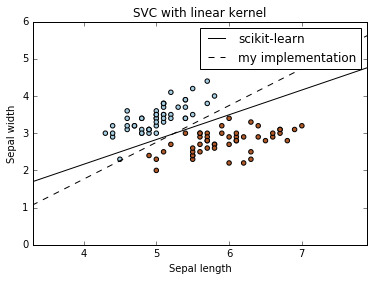

In [32]:
iris = datasets.load_iris()
X = iris.data[:100, :2]
y = iris.target[:100]
label = []
x = X
for i in range(len(y)):
    if y[i] == 0:
        label.append(-1)
    else:
        label.append(1)
last_col = np.array([1] * len(X))
train_data = np.c_[x,last_col]
C = 1.0
my_svm = SVM(C)
prediction = my_svm.train(train_data,label)
my_w0 = prediction[0]
my_w1 = prediction[1]
my_b = prediction[2]
svc = svm.LinearSVC(C=1)

svc.fit(X, y)
w = svc.coef_
b = svc.intercept_[0]

print("my svm parameters: w0,w1,b")
print()
h = 0.1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))

p_x = np.linspace(3,8)
p_y = []
my_y = []
for i in range(len(p_x)):
    temp1 = (-w[0][0]/w[0][1]) * p_x[i] - b/w[0][1]
    p_y.append(temp1)
    temp2 = (-my_w0/my_w1) * p_x[i] - my_b/my_w1
    my_y.append(temp2)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.plot(p_x,p_y,'k-', label='scikit-learn')
plt.plot(p_x,my_y,'k--',label='my implementation')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
plt.legend()
plt.show()